# Supplemental Figure 3

- Panel A: Blur distribution across channels and plate
- Panel B: Saturation distribution for all channels combined across plates

## Import libraries

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(arrow))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”


## Set paths

In [2]:
figure_dir <- "../figures/supplementary"
output_supp_figure_3 <- file.path(figure_dir, "supp_figure_3_qualitycontrol.png")

## Load in image quality data

In [3]:
# Path to quality control results
qc_results_dir <- file.path(
    "../../../nf1_cellpainting_data/1.cellprofiler_ic/image_quality_control"
)

# Load data
qc_results_file <- file.path(qc_results_dir, "concat_img_quality_data.parquet")

qc_results_df <- arrow::read_parquet(qc_results_file)

# Rename plates in Metadata_Plate column
qc_results_df <- qc_results_df %>%
  mutate(Metadata_Plate = recode(Metadata_Plate,
                                  "Plate_3" = "Plate A",
                                  "Plate_3_prime" = "Plate B",
                                  "Plate_5" = "Plate C"))

# Remove any plate 4 image sets
qc_results_df <- qc_results_df %>% dplyr::filter(Metadata_Plate != "Plate_4")

dim(qc_results_df)
head(qc_results_df)

[1] 20448     8

Metadata_Frame,Metadata_Series,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel,Metadata_Plate
<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
0,0,B10,10,-2.169082,0.061455261,DAPI,Plate A
0,0,B10,11,-2.288957,0.254768205,DAPI,Plate A
0,0,B10,12,-2.212145,0.024401353,DAPI,Plate A
0,0,B10,13,-2.259287,0.016900197,DAPI,Plate A
0,0,B10,14,-2.311723,0.106371826,DAPI,Plate A
0,0,B10,15,-2.283226,0.006597403,DAPI,Plate A


## Plot the blur metric per channel across plates

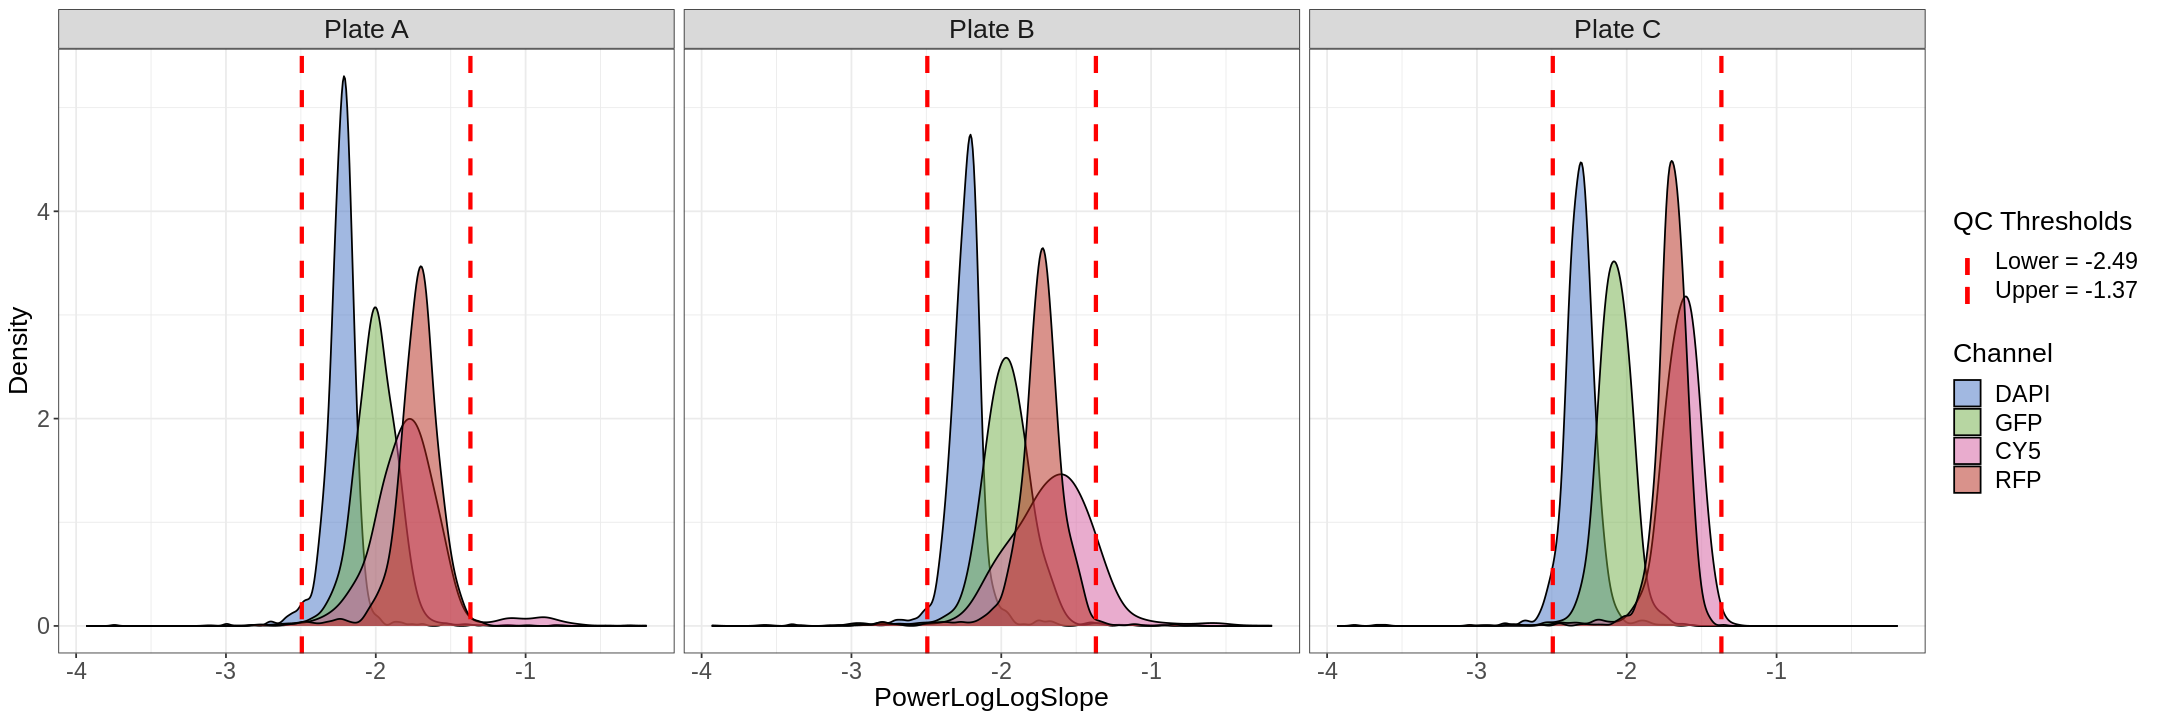

In [4]:
width <- 18
height <- 6
options(repr.plot.width = width, repr.plot.height = height)

# Ensure the Channel factor has the correct order
qc_results_df$Channel <- factor(qc_results_df$Channel, levels = c("DAPI", "GFP", "CY5", "RFP"))

# Threshold values
upper_threshold <- -1.36839084751248
lower_threshold <- -2.4936740062477365

# Create the plot with the specified color mapping
qc_blur_plot <- ggplot(qc_results_df, aes(x = ImageQuality_PowerLogLogSlope, fill = Channel)) +
    geom_density(alpha = 0.5, adjust = 1.5) + 
    scale_fill_manual(
        values = c("DAPI" = "#4472C4",  # Blue
                   "GFP" = "#70AD47",  # Green
                   "CY5" = "#D35B9D",  # Brighter magenta
                   "RFP" = "#b42718")  # Red
    ) +
    geom_vline(aes(xintercept = upper_threshold, color = paste("Upper =", round(upper_threshold, 2))), 
               linetype = "dashed", linewidth = 1.2) + 
    geom_vline(aes(xintercept = lower_threshold, color = paste("Lower =", round(lower_threshold, 2))), 
               linetype = "dashed", linewidth = 1.2) +  
    scale_color_manual(name = "QC Thresholds", values = c("Upper = -1.37" = "red", 
                                                          "Lower = -2.49" = "red")) +  # Set the color and label for the legend
    labs(
        x = "PowerLogLogSlope",
        y = "Density"
    ) +
    theme_bw() +
    facet_wrap(~ Metadata_Plate) +  # Facet by plate
    theme(
        strip.text = element_text(size = 16),   # Facet titles
        axis.title = element_text(size = 16),  # Axis titles
        axis.text = element_text(size = 14),   # Axis text
        legend.title = element_text(size = 16), # Legend title
        legend.text = element_text(size = 14)   # Legend text
    )

qc_blur_plot


## Plot saturation metric combining all channels comparing by plate

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


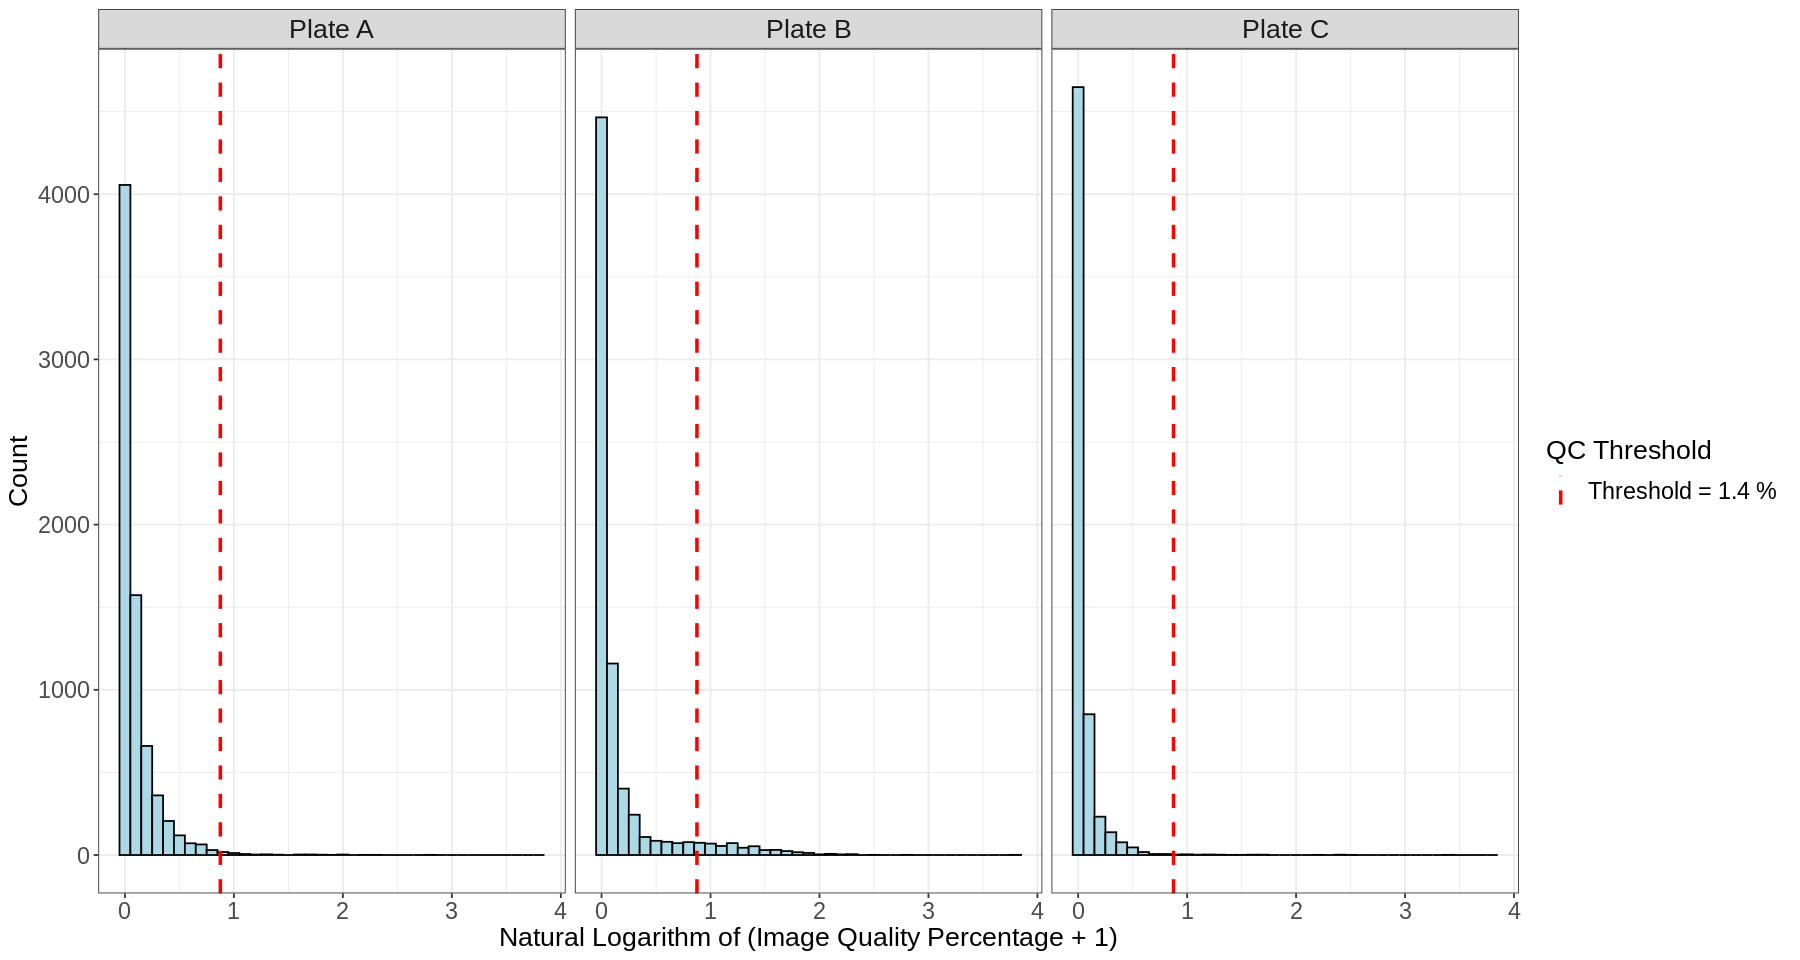

In [5]:
width <- 15
height <- 8
options(repr.plot.width = width, repr.plot.height = height)

# Take natural logarithm plus one of the percent maximal for better visualization
qc_results_df <- qc_results_df %>%
  mutate(LogImageQuality = log1p(ImageQuality_PercentMaximal))

# Create a label for the threshold line
original_threshold <- 1.4

# Create the plot
qc_saturation_plot <- ggplot(qc_results_df, aes(x = LogImageQuality)) +
  geom_histogram(binwidth = 0.1, fill = "lightblue", color = "black") +
  facet_wrap(~ Metadata_Plate) +
  geom_vline(aes(xintercept = log1p(original_threshold), 
                 color = paste("Threshold =", original_threshold, "%")),
             linetype = "dashed", size = 1) +
  scale_color_manual(name = "QC Threshold", values = "red") + # Customize the legend title and color
  labs(
    x = "Natural Logarithm of (Image Quality Percentage + 1)",
    y = "Count"
  ) +
  theme_bw() +
  theme(
    strip.text = element_text(size = 16),   # Facet titles
    axis.title = element_text(size = 16),  # Axis titles
    axis.text = element_text(size = 14),   # Axis text
    legend.title = element_text(size = 16), # Legend title
    legend.text = element_text(size = 14)   # Legend text
  )

qc_saturation_plot

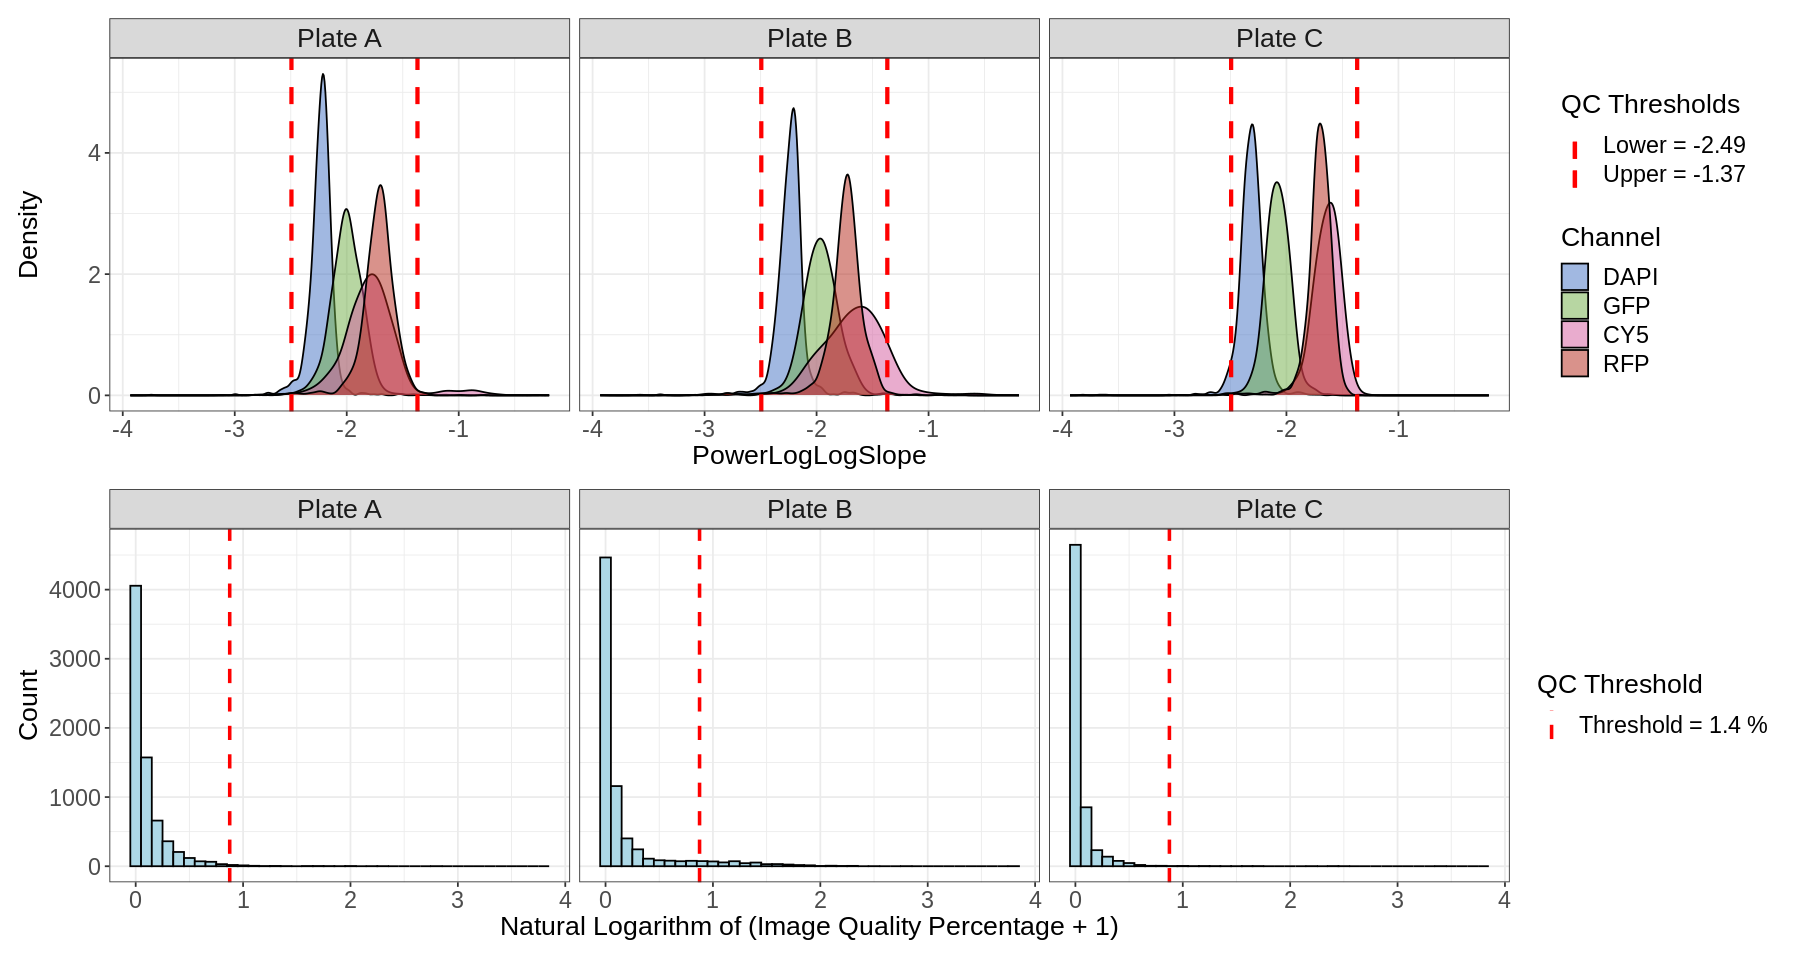

In [6]:
align_plot <- (
    qc_blur_plot /
    qc_saturation_plot 
) + plot_layout(heights= c(2,2))

align_plot

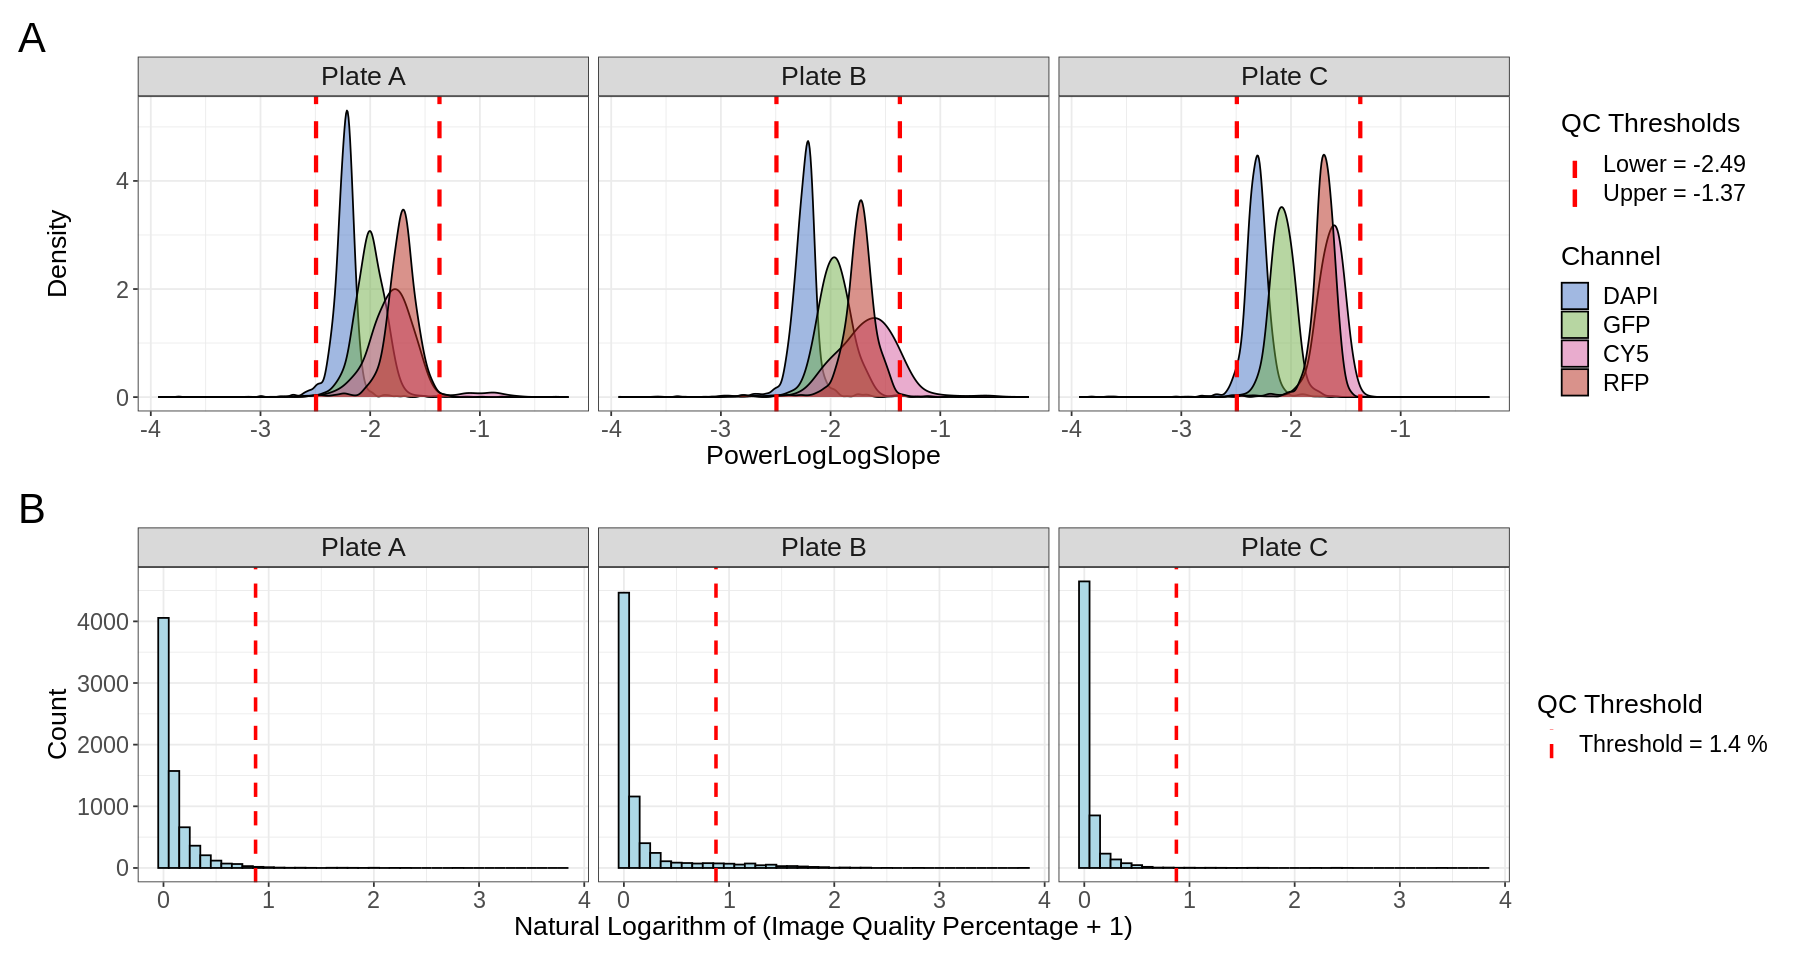

In [7]:
supp_fig_3_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save or display the plot
ggsave(output_supp_figure_3, plot = supp_fig_3_gg, dpi = 500, height = 8, width = 12)

supp_fig_3_gg